In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

data = pd.read_csv('movies.csv')

In [2]:
# Get information about the current dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63000 entries, 0 to 62999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    63000 non-null  int64  
 1   title                 63000 non-null  object 
 2   vote_average          63000 non-null  float64
 3   vote_count            63000 non-null  int64  
 4   status                63000 non-null  object 
 5   release_date          62973 non-null  object 
 6   revenue               63000 non-null  int64  
 7   runtime               63000 non-null  int64  
 8   budget                63000 non-null  int64  
 9   original_language     63000 non-null  object 
 10  popularity            63000 non-null  float64
 11  genres                62517 non-null  object 
 12  production_companies  56870 non-null  object 
 13  production_countries  60859 non-null  object 
 14  spoken_languages      62046 non-null  object 
dtypes: float64(2), int6

In [3]:
data.isnull()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,original_language,popularity,genres,production_companies,production_countries,spoken_languages
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62995,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
62996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
62997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
62998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


<Axes: >

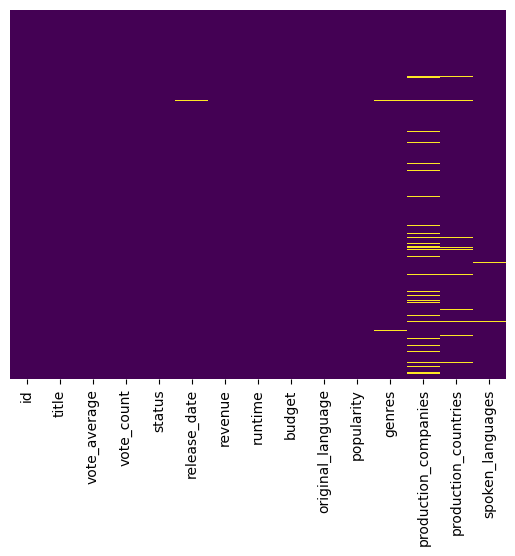

In [4]:
import seaborn as sns
sns.heatmap(data.isnull(),yticklabels=False, cbar=False, cmap='viridis')
# from this heatmap we can see that production_companies contains plenty missing values

<Axes: >

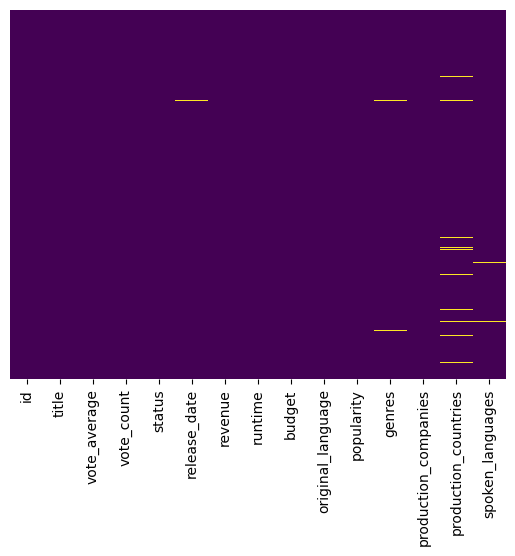

In [5]:
# Since there are many missing values but we need the column for analysis we will not drop it, just categorise the NAN's as unknown
# This is selected as the 'most frequent' strategy would does not preserve the information about missingness
data['production_companies'] = data['production_companies'].fillna('Unknown')
sns.heatmap(data.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [6]:
print(data['production_countries'].apply(type).value_counts())
print(data['status'].apply(type).value_counts())
print(data['genres'].apply(type).value_counts())
print(data['spoken_languages'].apply(type).value_counts())


production_countries
<class 'str'>      60859
<class 'float'>     2141
Name: count, dtype: int64
status
<class 'str'>    63000
Name: count, dtype: int64
genres
<class 'str'>      62517
<class 'float'>      483
Name: count, dtype: int64
spoken_languages
<class 'str'>      62046
<class 'float'>      954
Name: count, dtype: int64


In [7]:
# Zero to NaN
def replace_zeros(df):
    df = df.copy()
    cols = ['budget', 'revenue', 'runtime']
    for col in cols:
        if col in df.columns:
            df[col] = df[col].replace(0, np.nan)
    return df

# Date Extraction
def extract_date_features(df):
    df = df.copy()
    # Coverting the release date variable to data time object 
    df['release_date'] = pd.to_datetime(df['release_date'], dayfirst=True, format='mixed', errors='coerce')
    
    # Extract release year and release month from the release date variable
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month_name()
    return df

# Feature Engineering (ROI/Profit/Genre)
def create_business_features(df):
    df = df.copy()
    # Profit and ROI
    if 'revenue' in df.columns and 'budget' in df.columns:
        df['profit'] = df['revenue'] - df['budget']
        df['roi'] = (df['revenue'] - df['budget']) / df['budget']
    
    # Extracting primary genre
    if 'genres' in df.columns:
        df['primary_genre'] = df['genres'].astype(str).str.split(',').str[0]
        
    return df

In [ ]:
raw_data = pd.read_csv('movies.csv')

# Cleaning
def filter_noise(df):
    df = df.copy()
    # Drop Duplicates
    df = df.drop_duplicates()
    
    # Filter Outliers (Runtime 0 or > 300)
    df = df[(df['runtime'] > 0) & (df['runtime'] <= 300)]
    
    # Filter Vote Count (Reliability)
    df = df[df['vote_count'] >= 10]
    
    # Drop rows with no release date (important for the year analysis)
    temp_dates = pd.to_datetime(df['release_date'], dayfirst=True, format='mixed', errors='coerce')
    df = df[temp_dates.notna()]
    
    return df


df_filtered = filter_noise(raw_data)
print(f"Rows remaining after cleaning: {df_filtered.shape[0]}")

Rows remaining after filtering: 62216


In [ ]:
# Piplines used
analysis_pipeline = Pipeline(steps=[
    ('handle_zeros', FunctionTransformer(replace_zeros)),
    ('date_features', FunctionTransformer(extract_date_features)),
    ('feature_eng', FunctionTransformer(create_business_features))
])

# Running the pipeline
df_analysis = analysis_pipeline.fit_transform(df_filtered)

print("Preprocessing Complete!")
print(df_analysis.head())

# Save the new cleaned and preprocessed dataset
df_analysis.to_csv('movies_cleaned_analysis.csv', index=False)
print("The cleaned dataset is saved as 'movies_cleaned_analysis.csv'")

Preprocessing Complete!
       id            title  vote_average  vote_count    status release_date  \
0   27205        Inception         8.364       34495  Released   2010-07-15   
1  157336     Interstellar         8.417       32571  Released   2014-11-05   
2     155  The Dark Knight         8.512       30619  Released   2008-07-16   
3   19995           Avatar         7.573       29815  Released   2009-12-15   
4   24428     The Avengers         7.710       29166  Released   2012-04-25   

        revenue  runtime       budget original_language  popularity  \
0  8.255328e+08      148  160000000.0                en      83.952   
1  7.017292e+08      169  165000000.0                en     140.241   
2  1.004558e+09      152  185000000.0                en     130.643   
3  2.923706e+09      162  237000000.0                en      79.932   
4  1.518816e+09      143  220000000.0                en      98.082   

                                        genres  \
0           Action, Scie

In [ ]:
df_analysis = pd.read_csv('movies_cleaned_analysis.csv') 

# A copy
df_ml_input = df_analysis.copy()

numeric_cols = [
    'budget', 'revenue', 'runtime', 'vote_count', 'vote_average', 
    'popularity', 'release_year', 'profit', 'roi'
]


categorical_cols = ['original_language', 'primary_genre']

# The Pipelines

# for the numerical variables (budget, runtime, etc) use the median to handle missing values (using median is better against outliers)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# for categorical variables (language, genre) we are going to fill them with "Missing" or "Unknown" (this way it is safer than guessing it)
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_cols),
        ('cat', cat_pipeline, categorical_cols)
    ],
    #This is used to keep the names of the columns simple (suggested by AI)
    verbose_feature_names_out=False 
)

# Execute Transformation 
# We fit_transform the whole dataset to create the file
processed_array = preprocessor.fit_transform(df_ml_input)

# Reconstruct DataFrame 
# Get the new column names (Original Numeric + New One-Hot Names)
numeric_names = numeric_cols
categorical_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_columns = list(numeric_names) + list(categorical_names)

# Create the final dataframe
df_algorithms = pd.DataFrame(processed_array, columns=all_columns)

# Save the new file
df_algorithms.to_csv('movies_3.csv', index=False)

print("The dataset is created: 'movies_3.csv'")
print(f"Shape: {df_algorithms.shape}")
print(df_algorithms.head())

Dataset created: 'movies_3.csv'
Shape: (62216, 129)
      budget    revenue   runtime  vote_count  vote_average  popularity  \
0   9.005964  12.142514  1.714386   25.820394      2.188544    2.530396   
1   9.305318  10.279340  2.374875   24.366315      2.242083    4.425285   
2  10.502733  14.836751  1.840193   22.891074      2.338048    4.102182   
3  13.616012  43.718850  2.154712   22.283445      1.389510    2.395068   
4  12.598209  22.576032  1.557126   21.792957      1.527902    3.006062   

   release_year     profit       roi  original_language_af  ...  \
0      0.497841  12.114612 -0.006573                   0.0  ...   
1      0.658176   9.727639 -0.006640                   0.0  ...   
2      0.417673  14.968998 -0.006553                   0.0  ...   
3      0.457757  49.570763 -0.006037                   0.0  ...   
4      0.578008  23.850535 -0.006442                   0.0  ...   

   primary_genre_Horror  primary_genre_Music  primary_genre_Mystery  \
0                   0.0